### Webscraping from the general list of restaurants (without info on neighbourhoods)

This dataset contains all the restaurants in Valencia on the webpage TripAdvisor. I will not use the neighbourhood filters of TripAdvisor, because not all the restaurants are labeled with the neighbourhood. Instead I will take the address of all restaurants through their page, extract the postal code and map it to the corresponding neighbourhood.

In [1]:
from bs4 import BeautifulSoup as bs
#import requests
import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

import numpy as np
import time


In [14]:
service = Service(executable_path=ChromeDriverManager().install())

driver = webdriver.Chrome(service=service)

I go to the tripadvisor webpage and click on the "Accept all Cookies" button as a first step

In [15]:

url = "https://www.tripadvisor.com/Restaurants-g187529-Valencia_Province_of_Valencia_Valencian_Country.html"

driver.get(url)
#Scroll a bit to make cookie button appear (it doesn't really work always, I must open the browser window to make it appear)
driver.execute_script("window.scrollTo(0,2000);")

time.sleep(4)
Cookies = driver.find_element(by="xpath", value="/html/body/div[8]/div[2]/div/div[2]/div[1]/div/div[2]/div/div[1]/button")
Cookies.click()

Here the real webscraping starts. I want the following information from the ranking list of restaurants:
- Name of the restaurant
- Position in the ranking (this is contained inside the name of the restaurant, I will apply a split)
- Average vote
- Number of reviews
- Type of restaurant
- Price level (this is in the format of \$, \$\-\$\$, \$\$, etc)
- URL of the restaurant page (I need this to extract the address)

In this image I show where the information I want is stored on the table in the webpage:

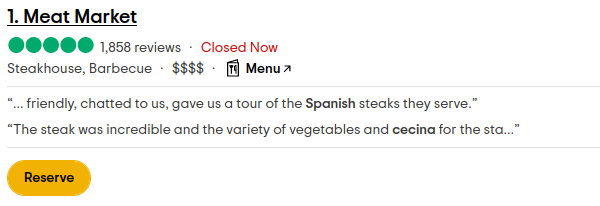


In [16]:

#they must be in this order, I will use it to map the price level into numbers
possible_prices = ['$$$ - $$$$', '$$ - $$$', '$ - $$', '$$$$', '$$$', '$$', '$']

list_names = []
list_rating = []
list_nReviews = []
list_type = []
list_price = []
list_urls = []
soup = bs(driver.page_source,"lxml")

n_restaurants = int(soup.select('span.SgeRJ span span.b')[0].get_text(strip=True))

#there are 30 ranked restaurants per page
for k in range(n_restaurants//30+1):
    for i in range(len(soup.select('div.tkvCJ.u.F.f.Ff.K'))):
        list_names.append(soup.select('div.RfBGI span a')[i].get_text(strip=True))
        list_urls.append(soup.select('div.RfBGI span a')[i]["href"])
        
        try:
            list_rating.append(float(soup.select('span.GmcgY svg.UctUV.d.H0')[i]["aria-label"].split()[0]))
            list_nReviews.append(int(soup.select('span.SUszq span a span.IiChw')[i].get_text().split()[0].replace(",","")))
        except:
            list_rating.append(np.nan)
            list_nReviews.append(0)
        
        #sometimes there is no price range, or no type of restaurant, or both!!
        #I take the entire upper block of html which contains both the type of restaurant and the price
        #and then I check what I have and split the string to append the text in the corresponding list
        #PROBLEM: sometimes in this text there is also "Taking safety measures" or "Menu". If the price range is not there
        # I might put these sentences together with the restaurant type, so I added a check to avoid this.

        checks = ["Taking safety measures", "Menu"]
        txt = soup.select('div.hBcUX.XFrjQ.mIBqD')[i].get_text(strip=True)
        t = ''
        price = ''
        for i,c in enumerate(txt):
            if c=='$':
                t = txt[0:i]
                break
            if i==len(txt)-1:
                t = txt
        #if the type of restaurant is not present, append a nan in the list
        if t =='':
            list_type.append(np.nan)
        #All these elif are to avoid adding the sentences in checks in the name of the restaurant
        elif checks[0] not in t and checks[1] not in t:
            list_type.append(t)
        elif checks[0] in t:
            list_type.append(t[0:-len(checks[0])])
        elif checks[1] in t:
            list_type.append(t[0:-len(checks[1])])
        else:
            list_type.append(t[0:-len(checks[1])-len(checks[0])])
        #This part is to extract the price level from the string
        for p in possible_prices:
            if txt == '':
                price = np.nan
                break
            if p in txt:
                price = p
                break
            else:
                price = np.nan
        
        list_price.append(price)
    print(k)

    # Finally I press the "next" button to change page. I don't want to press next on the last page (there is no next)
    if k < n_restaurants//30:
        driver.execute_script("window.scrollTo(0,document.body.scrollHeight-1300);")
        time.sleep(3)
        next = driver.find_element(By.CLASS_NAME, 'nav.next.rndBtn.ui_button.primary.taLnk')
        next.click()
        time.sleep(3)
        #take the soup from new page
        soup = bs(driver.page_source,"lxml")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


In [17]:
array_names = np.array(list_names)
array_ratings = np.array(list_rating)
array_nReviews = np.array(list_nReviews)
array_prices = np.array(list_price)
array_types = np.array(list_type)
array_urls = np.array(list_urls)

In [18]:
len(array_names)

3771

array_names contains both the ranking and the name of the restaurant, divided by a ".", see for example


On the webpage there are "Sponsored" restaurants appearing in the ranking list. These restaurants appear without a ranking number like in the following picture

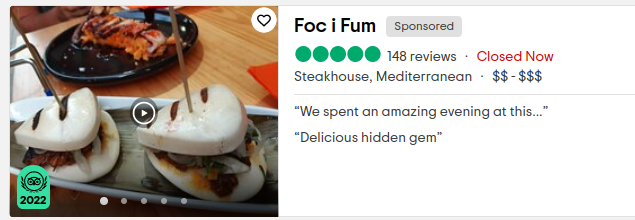

To identify them and delete them, I check all the indices which do not contain a "." and slice my arrays with these indices

In [19]:
indices = np.where([[name]!=name.split(".") for name in array_names])
indices

(array([   0,    1,    2, ..., 3768, 3769, 3770]),)

In [20]:
array_names = array_names[indices]
array_ratings = array_ratings[indices]
array_nReviews = array_nReviews[indices]
array_prices = array_prices[indices]
array_types = array_types[indices]
array_urls = array_urls[indices]

Now for all the remaining restaurants I split the ranking and the name

In [21]:
array_rankings = [name.split(".")[0].strip() for name in array_names]
array_names = [name.split(".")[1].strip() for name in array_names]

Then I use a dictionary to map the price levels into numbers

In [22]:
price_dictio = {'$' : 1, '$ - $$' : 2,  '$$' : 3, '$$ - $$$' : 4, '$$$' : 5,  '$$$ - $$$$' : 6,  '$$$$' : 7, np.nan : np.nan, "nan" : np.nan}
level_prices = [price_dictio[price] for price in array_prices]

I replace "," with ";" in restaurant type to avoid problems if I save the DataFrame into csv

In [23]:
array_types = [t.replace(",",";") if type(t)!=float else t for t in array_types]

In [24]:
list_types = [t.replace(",",";") if type(t)!=float else t for t in list_type]

Finally I save everything in a pandas DataFrame

In [155]:
df_TripAdvisor_total = pd.DataFrame({"Restaurant name" : array_names,
                               "Ranking": array_rankings, "Number of reviews"  : array_nReviews,
                               "Average vote" : array_ratings, "Price range" : array_prices,
                               "Price level" : level_prices, "Restaurant type" : array_types,
                               "urls" : array_urls
                               })

In [26]:
df_TripAdvisor_total

,Restaurant name,Ranking,Number of reviews,Average vote,Price range,Price level,Restaurant type,urls
0,Meat Market,1,1839,5.0,$$$$,7.0,Steakhouse; Barbecue,/Restaurant_Review-g187529-d7214200-Reviews-Me...
1,Restaurante Nou Chocomeli,2,1009,5.0,$$$$,7.0,Mediterranean; Spanish,/Restaurant_Review-g187529-d17437058-Reviews-R...
2,Grillo Grill Bar,3,616,5.0,$$ - $$$,4.0,Mediterranean; Barbecue,/Restaurant_Review-g187529-d17529488-Reviews-G...
3,Restaurante Gordon 10,4,2614,4.5,$$ - $$$,4.0,Steakhouse; Barbecue,/Restaurant_Review-g187529-d2708555-Reviews-Re...
4,Santa Rita,5,240,5.0,nan,NaN,Italian,/Restaurant_Review-g187529-d25219166-Reviews-S...
...,...,...,...,...,...,...,...,...
3677,Gino Banana,3708,0,NaN,$,1.0,Pizza,/Restaurant_Review-g187529-d25224325-Reviews-G...
3678,Masquetapasburjasot,3709,0,NaN,nan,NaN,Cafe; Mediterranean,/Restaurant_Review-g187529-d25356980-Reviews-M...
3679,La Creu,3710,0,NaN,nan,NaN,nan,/Restaurant_Review-g15269138-d19850332-Reviews...
3680,Tandoori Station Restaurante,3711,0,NaN,nan,NaN,nan,/Restaurant_Review-g15269138-d22832707-Reviews...


### First cleaning of the dataframe

As a first cleaning step I will delete all the restaurants which have NaN in both the type of restaurant and the number of reviews, because there is no interesting information from these entries of my dataframe.

In [156]:
mask1 = df_TripAdvisor_total["Number of reviews"] == 0
mask2 = df_TripAdvisor_total["Restaurant type"]=="nan"
print(len(np.where((mask1) & (mask2))[0]))
df_TripAdvisor_total = df_TripAdvisor_total.drop(np.where((mask1) & (mask2))[0])

181


### Back to WebScraping to get the addresses of the restaurants

In the ranking webpage the information about the address of the restaurants wasn't shown, so I have to go to each restaurant page on TripAdvisor to get this information. For this reasong I saved all the urls in the first Scraping.

In [41]:
service = Service(executable_path=ChromeDriverManager().install())

driver = webdriver.Chrome(service=service)

[WDM] - Downloading: 100%|██████████| 6.83M/6.83M [00:10<00:00, 690kB/s] 


In [42]:
url = "https://www.tripadvisor.com/Restaurants-g187529-Valencia_Province_of_Valencia_Valencian_Country.html"

driver.get(url)
#Scroll a bit to make cookie button appear
driver.execute_script("window.scrollTo(0,2000);")

time.sleep(4)
Cookies = driver.find_element(by="xpath", value="/html/body/div[8]/div[2]/div/div[2]/div[1]/div/div[2]/div/div[1]/button")
Cookies.click()

In [43]:
#list_addresses = []

list_names = list(np.zeros(len(list_addresses))) #[]
for k in range(len(list_addresses), len(df_TripAdvisor_total)):
    list_names.append(df_TripAdvisor_total["Restaurant name"].iloc[k])
    url = "https://www.tripadvisor.com" + df_TripAdvisor_total["urls"].iloc[k]
    driver.get(url)
    time.sleep(2)
    soup = bs(driver.page_source,"lxml")
    if len(soup.select('span.DsyBj.cNFrA span a.AYHFM'))>0:
        list_addresses.append(soup.select('span.DsyBj.cNFrA span a.AYHFM')[0].get_text(strip=True))
    else:
        list_addresses.append(np.nan)
    print(k)

1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117


I add the list of addresses as a new column in the DataFrame

In [ ]:
df_TripAdvisor_total["address"] = list_addresses

Let's find the postal code of each restaurant from the address. Most of the times the address follow this format 



But life is not always sweet, so some of the addresses don't follow the general format, and sometimes the postal code is missing.  Luckily with just a few checks which I applied in the code below it seems to be working for all the entries.

In [229]:
splitted = [x.split(",") for x in df_TripAdvisor_total["address"]]

list_caps = []
for elem in splitted:
    flag = False
    for x in elem:
        #if len(x.strip())==5 and x.strip().isnumeric():
        if x[1:6].isnumeric() and x[1:3]=="46": #postal codes of Valencia starts with "46"
            flag = True
            list_caps.append(x[1:6])
            break
    if flag==False:
        list_caps.append(np.nan)

len(list_caps)


3501

Let's add the information to a new column in the dataframe, and drop the urls column which I don't need anymore

In [236]:
df_TripAdvisor_total["Postal code"] = list_caps

In [240]:
df_TripAdvisor_total = df_TripAdvisor_total.drop("urls", axis=1)

## More cleaning

Let's try to delete duplicated restaurants. First thing I will apply a mask to the DataFrame to identify all the restaurants which have the same name.

In [241]:
repeated_names = [name for name, value in df_TripAdvisor_total["Restaurant name"].value_counts().items() if value!=1]

In [242]:
df_rep_names = df_TripAdvisor_total[df_TripAdvisor_total["Restaurant name"].isin(repeated_names)].sort_values(by="Restaurant name")

In [243]:
df_rep_names

,Restaurant name,Ranking,Number of reviews,Average vote,Price range,Price level,Restaurant type,address,postal code
1641,100 Montaditos,1672,112,3.5,$,1.0,Fast Food; European,"Avenida Autopista Del Saler 16, 46012, Valenci...",46012
2150,100 Montaditos,2181,2,5.0,nan,NaN,Bar; Pub,"Carrer del Consolat del Mar, 1, 46005, Valenci...",46005
2938,100 Montaditos,2969,5,3.0,nan,NaN,Fast Food; Spanish,"Carrer de Gayano Lluch, 30, 46025, Valencia Spain",46025
2808,Alhambra,2839,2,3.5,nan,NaN,nan,"Avenida Valladolid 6, 46020, Valencia Spain",46020
1030,Alhambra,1061,201,4.0,$,1.0,Spanish,"8 Carrer de Calixto III, 46008, Valencia Spain",46008
...,...,...,...,...,...,...,...,...,...
3444,llaollao,3475,0,NaN,$,1.0,Healthy,"Carrer del Micalet, 3, 46001, Valencia Spain",46001
3489,llaollao,3520,0,NaN,$,1.0,Healthy,Calle Santa Genoveva Torres 21 C.C. Arena Mult...,46019
3032,llaollao,3063,1,2.0,$,1.0,Cafe,"Autovía Del Este, Km. 345 C.C. Bonaire, 46960,...",46960
3022,llaollao,3053,4,3.0,nan,NaN,Cafe,"C. de Sant Vicent Màrtir, 8, 46002, Valencia S...",46002


Some of the restaurants are franchise with different locations, so I cannot drop them without further investigating. I will drop instead all the restaurants with same name and same address.

In [244]:
indices = df_rep_names[df_rep_names["address"].duplicated()].index

In [245]:
len(indices)

4

In [246]:
df_rep_names = df_rep_names.drop(indices)
df_TripAdvisor_total = df_TripAdvisor_total.drop(indices)

Good, I deleted 4 duplicated restaurants, but this is not enough. Sometimes the address is slighly different due to typos or different format or different language (Spanish or Valencian), so the only way is to be patient and investigate the dataframe manually. I save in a csv the names and addresses and I look at them. 

In [247]:
df_rep_names[["Restaurant name", "address"]].to_csv("check.csv")

After investigating I found other 22 repeated restaurants, which I drop here

In [249]:
df_TripAdvisor_total = df_TripAdvisor_total.drop([3311, 2930, 3389,
                                                  3508, 2752, 1901,
                                                  3336, 1476, 2580,
                                                  3513, 3440, 3467,
                                                  3272, 2364, 3567,
                                                  3626, 1961, 3318,
                                                  3658, 3143, 3503, 
                                                  2307, ])

Let's reset the index, as I dropped rows

In [250]:
df_TripAdvisor_total = df_TripAdvisor_total.reset_index()
df_TripAdvisor_total = df_TripAdvisor_total.drop("index", axis = 1)

In [251]:
df_TripAdvisor_total

,Restaurant name,Ranking,Number of reviews,Average vote,Price range,Price level,Restaurant type,address,postal code
0,Meat Market,1,1839,5.0,$$$$,7.0,Steakhouse; Barbecue,"Calle Burriana 38 Bajo, 46005, Valencia Spain",46005
1,Restaurante Nou Chocomeli,2,1009,5.0,$$$$,7.0,Mediterranean; Spanish,Calle del Mar 52 Parking Glorieta Paz 50 meter...,46003
2,Grillo Grill Bar,3,616,5.0,$$ - $$$,4.0,Mediterranean; Barbecue,"Carrer de Salamanca 7, 46005, Valencia Spain",46005
3,Restaurante Gordon 10,4,2614,4.5,$$ - $$$,4.0,Steakhouse; Barbecue,"Calle del Conde de Altea 49, 46005, Valencia S...",46005
4,Santa Rita,5,240,5.0,nan,NaN,Italian,"Calle Assaonadors 10, 46001, Valencia Spain",46001
...,...,...,...,...,...,...,...,...,...
3470,Restaurante Mexicano Margarita,3706,0,NaN,nan,NaN,Mexican,"Placa Vicente Iborra 4, 46003, Valencia Spain",46003
3471,The Corner Burger Club,3707,0,NaN,nan,NaN,American,"Carrer Del Riu Eresma, 1, 46026 València, Vale...",46026
3472,Gino Banana,3708,0,NaN,$,1.0,Pizza,"Carrer de Puerto Rico, 3 Barrio de Ruzafa, 460...",46006
3473,Masquetapasburjasot,3709,0,NaN,nan,NaN,Cafe; Mediterranean,"Calle Félix Pizcueta, 12 Bajo, 46100, Valencia...",46100


Some of the restaurants show 2 different types. I prefer to save the types into separated columns

In [252]:
df_TripAdvisor_total["Restaurant type 1"] = [elem[0].strip() if type(elem)!=float else np.nan for elem in df_TripAdvisor_total["Restaurant type"].str.split(";")]
df_TripAdvisor_total["Restaurant type 2"] = [elem[1].strip() if type(elem)!=float and len(elem)>1 else np.nan for elem in df_TripAdvisor_total["Restaurant type"].str.split(";")]

In [253]:
df_TripAdvisor_total = df_TripAdvisor_total.drop("Restaurant type", axis=1)

In [264]:
df_TripAdvisor_total

,Restaurant name,Ranking,Number of reviews,Average vote,Price range,Price level,address,Postal code,Restaurant type 1,Restaurant type 2
0,Meat Market,1,1839,5.0,$$$$,7.0,"Calle Burriana 38 Bajo, 46005, Valencia Spain",46005,Steakhouse,Barbecue
1,Restaurante Nou Chocomeli,2,1009,5.0,$$$$,7.0,Calle del Mar 52 Parking Glorieta Paz 50 meter...,46003,Mediterranean,Spanish
2,Grillo Grill Bar,3,616,5.0,$$ - $$$,4.0,"Carrer de Salamanca 7, 46005, Valencia Spain",46005,Mediterranean,Barbecue
3,Restaurante Gordon 10,4,2614,4.5,$$ - $$$,4.0,"Calle del Conde de Altea 49, 46005, Valencia S...",46005,Steakhouse,Barbecue
4,Santa Rita,5,240,5.0,nan,NaN,"Calle Assaonadors 10, 46001, Valencia Spain",46001,Italian,NaN
...,...,...,...,...,...,...,...,...,...,...
3470,Restaurante Mexicano Margarita,3706,0,NaN,nan,NaN,"Placa Vicente Iborra 4, 46003, Valencia Spain",46003,Mexican,NaN
3471,The Corner Burger Club,3707,0,NaN,nan,NaN,"Carrer Del Riu Eresma, 1, 46026 València, Vale...",46026,American,NaN
3472,Gino Banana,3708,0,NaN,$,1.0,"Carrer de Puerto Rico, 3 Barrio de Ruzafa, 460...",46006,Pizza,NaN
3473,Masquetapasburjasot,3709,0,NaN,nan,NaN,"Calle Félix Pizcueta, 12 Bajo, 46100, Valencia...",46100,Cafe,Mediterranean


### Adding the neighbourhood information

I prepared a csv with postal codes and the corresponding neighbourhood. I will use it to map the restaurants in the corresponding boroughs.

In [2]:
df_caps = pd.read_csv("../data/postal_codes.csv", index_col="Unnamed: 0")
df_caps.head(5)

,Postal code,Boroughs
0,46004,l'Eixample
1,46005,l'Eixample
2,46006,l'Eixample
3,46010,El Pla del Real
4,46001,Ciutat Vella


In [4]:
df_caps["Postal code"] = df_caps["Postal code"].astype("str")

In [ ]:
df_TripAdvisor_total = df_TripAdvisor_total.join(df_caps.set_index("Postal code"), on = "Postal code")

I also prepared another csv with population and average income for each borough. Let's add this information into the total DataFrame.

The information about the number of residents for each postal code is dated 2021 and it is taken from the [Generalitat Valenciana website](https://pegv.gva.es/es/temas/demografiaypoblacion/poblacion/padronmunicipalcontinuoexplotacionestadistica/estimaciondelapoblacionempadronadaporcodigospostales)

The information about the average income is dated 2020; I took this information from the article on [ValenciaPlaza](https://valenciaplaza.com/jorge-juan-rascanya-calles-valencia-mayor-menor-renta-espana), and they extracted it from the [Instituto Nacional de Estadística](https://www.ine.es/)

In [3]:
df_info = pd.read_csv("../data/boroughs.csv", index_col="Unnamed: 0")
df_info.head(5)

,Boroughs,Population,Income
0,Algirós,68400,15105
1,Benicalap,33298,11520
2,Benimaclet,46868,14834
3,Camins al Grau,46154,13788
4,Campanar,35767,15126


In [293]:
df_TripAdvisor_total = df_TripAdvisor_total.join(df_info.set_index("Boroughs"), on = "Boroughs")

Finally my DataFrame is ready to be used, so I save it as a csv

In [294]:
df_TripAdvisor_total.to_csv("--/data/df_TripAdvisor_total_boroughs.csv")